In [3]:
# Data Management/Investigation
import pandas as pd
import numpy as np
import missingno as miss
from plotnine import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestRegressor as RF

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline


In [7]:
# Load in training data and check shape
dat = pd.read_csv("train_data.csv")
dat.shape

(43590, 39)

<AxesSubplot:>

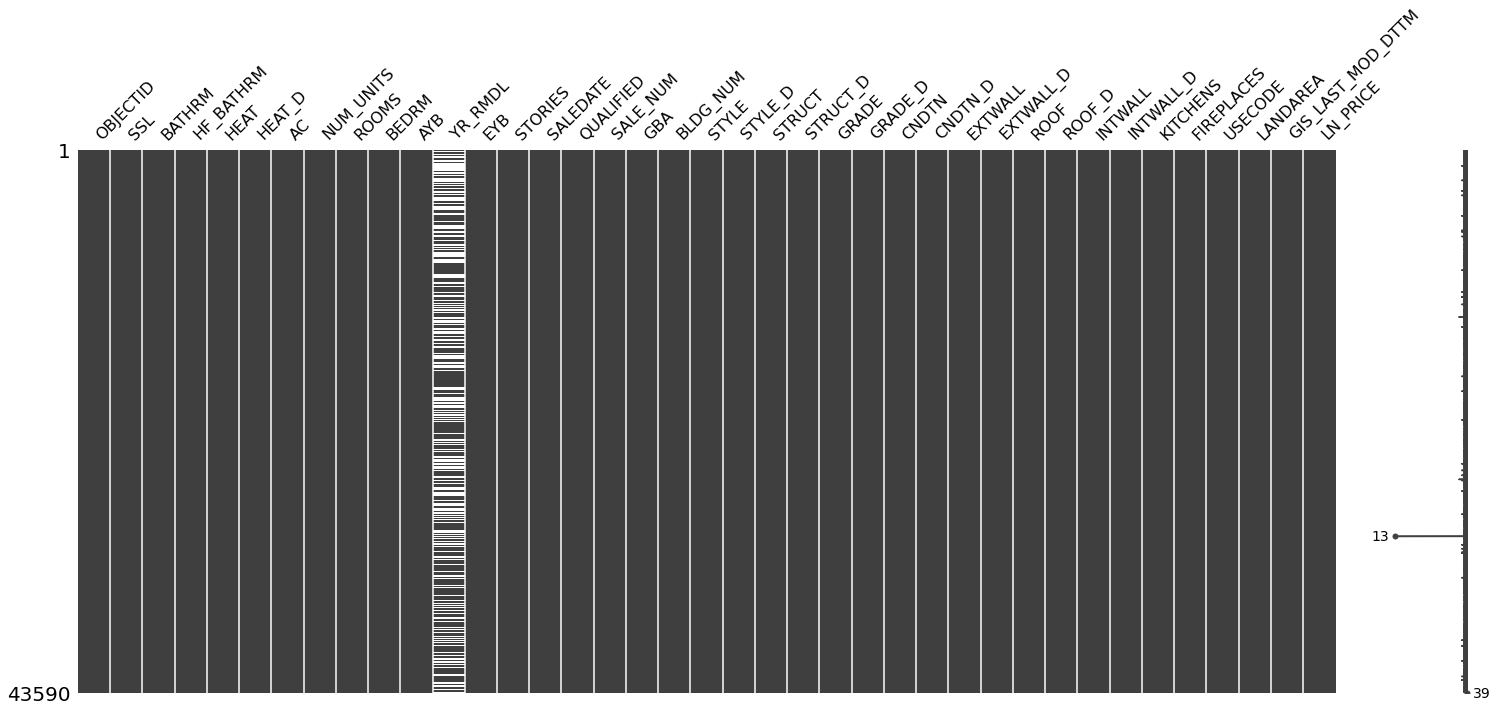

In [8]:
#spot check for missing data
miss.matrix(dat)

In [40]:
#identify predictors
pred = ["BATHRM", "ROOMS", "BEDRM", "GRADE"]

#clean train data

#drop na for predictors
dat = dat.dropna(subset=pred)

#keep houses that were sold
dat = dat[dat.LN_PRICE > 0]

In [44]:
#split into x and y
train_x = dat[pred]
train_y = dat.LN_PRICE

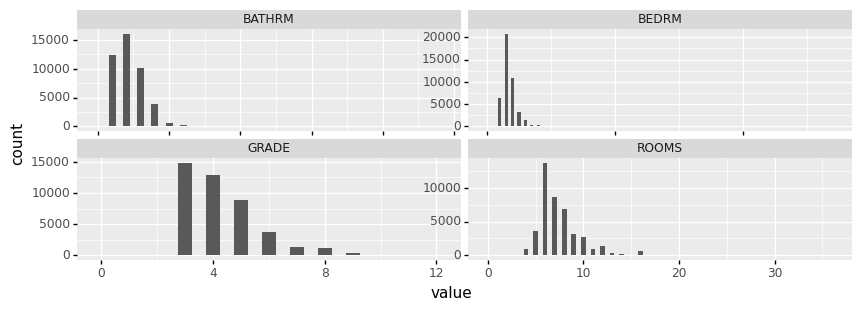

<ggplot: (324563975)>

In [49]:
#look at how the data is distributed for each value
(
    ggplot(train_x.melt(), aes(x = "value")) +
    geom_histogram(binwidth = 0.5) +
    facet_wrap("variable", scales = "free") +
    theme(figure_size = (10, 3))
)

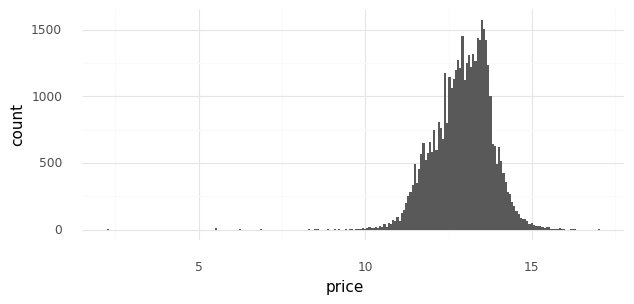

<ggplot: (325466874)>

In [45]:
#look at the outcome to spot red flags
(
    ggplot(pd.DataFrame(dict(price=train_y)),
           aes(x="price")) +
    geom_histogram() +
    theme_minimal() +
    theme(figure_size = (7,3)) 
)

The outcome looks good

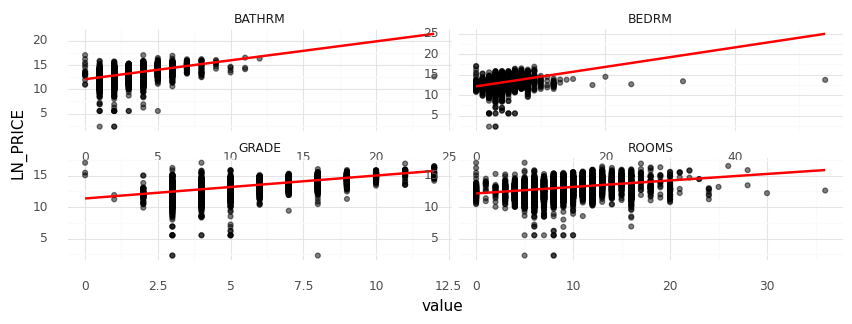

<ggplot: (325014007)>

In [48]:
#look at how predictors relate to outcome
dupeTrain = train_x.copy()
dupeTrain['LN_PRICE'] = train_y

(
    ggplot(dupeTrain.melt(id_vars=["LN_PRICE"]),
           aes(x="value",y="LN_PRICE"))+
    geom_point(alpha=.5) +
    facet_wrap("variable",scales="free") +
    geom_smooth(method="lm",se=False,color="red") +
    theme_minimal() +
    theme(figure_size = (10,3)) 
)

In [58]:
##Following procedure from class:

#Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=121)



In [59]:

#Next specify the preprocessing steps
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), pred)])


In [60]:
#Next create model pipe 
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])



In [61]:
# Specify the models and their repsective tuning parameters
search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[10,15,20,25,30]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[1,2,3,5]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1,2,3],
     'model__n_estimators':[500,1000,1250]},
]


In [62]:
# Put it all together in the grid search
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)


In [63]:
# Fit the model to the training data
search.fit(train_x,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=121, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['BATHRM',
                                                                          'ROOMS',
                                                                          'BEDRM',
                                                                          'GRADE'])])),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [LinearRegression()]},
                         {'model': [KNeighborsRegressor()],
                          'model__n_neighbors': [10, 15, 20, 25, 30]},
                         {'model': [DecisionTreeRegressor(max_depth=5)],
                          'm

In [64]:
#identify best score
search.best_score_

-0.4277564050755598

In [65]:
#identify best model
search.best_params_

{'model': DecisionTreeRegressor(max_depth=5), 'model__max_depth': 5}

##TEST MODEL

In [66]:
#import test data
dat2 = pd.read_csv("test_data.csv")

#clean test data

#drop na for predictors
dat2 = dat2.dropna(subset=pred)

#keep houses that were sold
dat2 = dat2[dat2.LN_PRICE > 0]

In [67]:
#split into x and y
test_x = dat2[pred]
test_y = dat2.LN_PRICE

In [68]:
# Predict() method will use the best model out of the scan
pred_y = search.predict(test_x)

In [69]:
#calc mean squared error
m.mean_squared_error(test_y,pred_y)

0.4312882974088022

In [70]:
#calc r squared
m.r2_score(test_y,pred_y)

0.41678618645769105

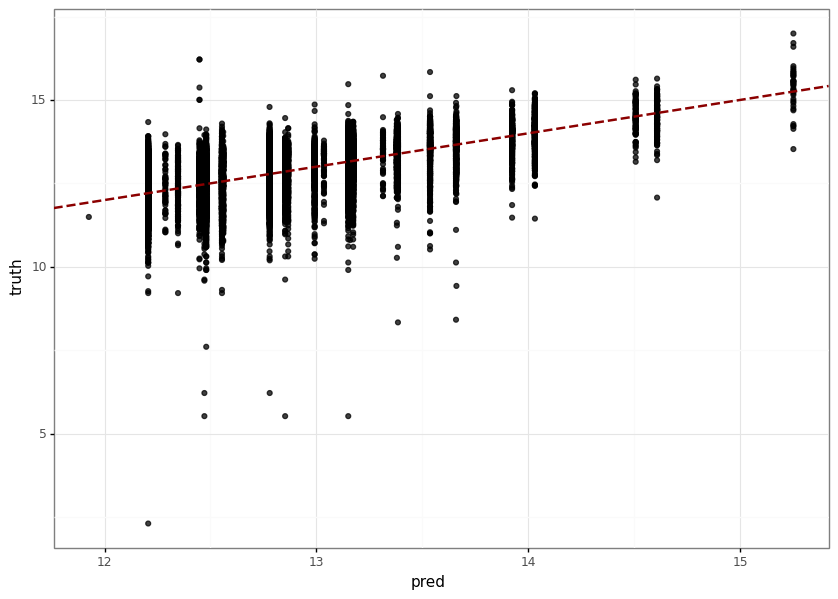

<ggplot: (328607693)>

In [71]:
(
    ggplot(pd.DataFrame(dict(pred=pred_y,truth=test_y)),
          aes(x='pred',y="truth")) +
    geom_point(alpha=.75) +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    theme_bw() +
    theme(figure_size=(10,7))
)

The decision tree model with max depth of 5 ended up being my best predictor. The reported mean squared error was .431 and the r_squared was 0.42.